# Libraries

In [1]:
# Import libraries. 
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import sklearn.metrics as sk
import math as m
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import scipy.stats as st
from scipy.stats import skew
from scipy.stats import kurtosis
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, HTML
from IPython.display import display_html 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingRegressor 
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import svm


# Setup for visualization

In [2]:
# Display all outputs in this Jupyter notebook, not only the last results.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# Set parameters for better visualizations and a color palette. 
sns.set_palette("crest")
plt.rcParams.update({'figure.max_open_warning': 0})
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

# Ensure that no warning is displayed in cases when there are some values replaced in a specific dataframe. 
pd.options.mode.chained_assignment = None

# Data 
## Load

In [3]:
# Load a dataset.
df = pd.read_csv("./Traffic_crashes_data.csv")

## Overview

In [4]:
# Drop columns ID, the accident date and the notification date. These are useless for mathematical modelling. 
df = df.drop(columns=["CRASH_RECORD_ID", "CRASH_DATE", "DATE_POLICE_NOTIFIED"])

# Location within the city will be determined by street names and their direcions. 
df = df.drop(columns=["LOCATION", "LONGITUDE", "LATITUDE"])

# In addition, details of street number and police zones are redundant. 
df = df.drop(columns=["STREET_NO", "BEAT_OF_OCCURRENCE"])

# dropping street name - from feature importance of models, it was not an important feature + generalization of the model for our use case
df = df.drop(columns=["STREET_NAME"])

# REPORT_TYPE is not valid for our usecase as this feature is generated after the police is called/crash is reported
df = df.drop(columns=["REPORT_TYPE"])

# INJURIES_REPORTED_NOT_EVIDENT again not useful for our usecase for the same reason as REPORT_TYPE
df = df.drop(columns=["INJURIES_REPORTED_NOT_EVIDENT"])

In [5]:
df['DAMAGE'] = df['DAMAGE'].replace({'$501 - $1,500': 'LESS THAN $1,500', '$500 OR LESS': 'LESS THAN $1,500'})

## Categorical and numerical variables

In [6]:
# VARIABLES_CAT_NUM 
# The function separates variables to categorical (low number of unique values), numerical (high number of unique values
# and data type int or float) and unclassified (for example high number of unique values and data type object). 
def variables_cat_num(dataframe, min_unique, max_unique):
    global list_cat, list_num, list_uncla
    list_cat = []
    list_num = []
    list_uncla = []
    for var in dataframe.columns:
        unique_count =  dataframe[var].nunique() 
        if  min_unique <= unique_count <= max_unique: 
            list_cat.append(var)
        elif var in dataframe.select_dtypes(include=np.number).columns.tolist():
            list_num.append(var)
        else:
            list_uncla.append(var)
    print("There are probably " + str( len(list_cat) ) + " categorical variables (with a few unique values):\n")
    display(dataframe[list_cat].dtypes)
    print("Also, there are probably " + str( len(list_num) ) + " numerical variables (with a lot of unique numerical values):\n")
    display(dataframe[list_num].dtypes)
    print(str( len(list_uncla) ) + " variables have remained unclassified:\n")
    display(dataframe[list_uncla].dtypes)

In [7]:
# Divide variables to categorical/numerical.
variables_cat_num(df, 2, 8)

There are probably 21 categorical variables (with a few unique values):



CRASH_DATE_EST_I           object
DEVICE_CONDITION           object
LIGHTING_CONDITION         object
ALIGNMENT                  object
ROADWAY_SURFACE_COND       object
ROAD_DEFECT                object
CRASH_TYPE                 object
INTERSECTION_RELATED_I     object
NOT_RIGHT_OF_WAY_I         object
HIT_AND_RUN_I              object
DAMAGE                     object
STREET_DIRECTION           object
PHOTOS_TAKEN_I             object
STATEMENTS_TAKEN_I         object
DOORING_I                  object
WORK_ZONE_I                object
WORK_ZONE_TYPE             object
WORKERS_PRESENT_I          object
MOST_SEVERE_INJURY         object
INJURIES_FATAL            float64
CRASH_DAY_OF_WEEK           int64
dtype: object

Also, there are probably 10 numerical variables (with a lot of unique numerical values):



POSTED_SPEED_LIMIT               int64
LANE_CNT                       float64
NUM_UNITS                        int64
INJURIES_TOTAL                 float64
INJURIES_INCAPACITATING        float64
INJURIES_NON_INCAPACITATING    float64
INJURIES_NO_INDICATION         float64
INJURIES_UNKNOWN               float64
CRASH_HOUR                       int64
CRASH_MONTH                      int64
dtype: object

6 variables have remained unclassified:



TRAFFIC_CONTROL_DEVICE     object
WEATHER_CONDITION          object
FIRST_CRASH_TYPE           object
TRAFFICWAY_TYPE            object
PRIM_CONTRIBUTORY_CAUSE    object
SEC_CONTRIBUTORY_CAUSE     object
dtype: object

In [8]:
# All unclassified variables have been checked. They are categorical by nature. 
list_cat = list_cat + list_uncla

In [9]:
# VARIABLES_CAT_RETYPE
# The function retypes categorical variables to the object dtype due to consistency of data types.
def variables_cat_retype(dataframe, list_var):
    for i in list_var:
        dataframe[i] = dataframe[i].astype('object')
    return dataframe

# Similarly, retype all numeric variables to float64.
def variables_num_retype(dataframe, list_var):
    for i in list_var:
        dataframe[i] = dataframe[i].astype('float64')
    return dataframe

In [10]:
# Change data types for categorical variables.
df = variables_cat_retype(df, list_cat)

In [11]:
# Change data types for numerical variables.
df = variables_num_retype(df, list_num)

# Exploratory data analysis 

## Raw data

In [12]:
# Drop unary variables (those with only one unique value).
df = df.drop(columns=["INJURIES_UNKNOWN"])
list_num.remove("INJURIES_UNKNOWN")

## Data quality

### Duplicates

In [13]:
# Drop duplicates (all values are the same as in another row).
print("There are " + str( df.duplicated().sum() ) + " duplicated rows in the dataset that will be removed.")
df.drop_duplicates(inplace = True)
print("The number of rows after removing duplicates is " + str(df.shape[0]) + ".")

There are 2773 duplicated rows in the dataset that will be removed.
The number of rows after removing duplicates is 792183.


### Missing values

In [14]:
# CHECK_NAN
# The function checks for variables with more missing values than the given ratio. You can drop these variables or replace
# the missing values with median/mode (numerical/categorical) using the last parameter. 
def check_nan(dataframe, list_var, max_empty_ratio, replace = False, drop = False):
    df_check = pd.DataFrame( data = dataframe[list_var] )
    
    # The list of problematic variables will be stored in a global variable. 
    global list_nan
    list_nan = []
    for var in df_check.columns:
        # Calculate the missing ratio.
        empty_ratio = dataframe[var].isna().sum() / dataframe[var].shape[0]
        # Compare the missing ratio to the given threshold.
        if empty_ratio > max_empty_ratio: 
            list_nan.append(var)
            # Values might be replaced by median or mode. 
            if replace:
                if ( dataframe[var].dtype.kind in 'iuf'):
                    dataframe[var] = dataframe[var].fillna( dataframe[var].median() )
                else:
                    dataframe[var] = dataframe[var].fillna( dataframe[var].mode()[0] )
            # Values might be dropped.     
            if drop: 
                dataframe.drop(columns = [var], axis = 1, inplace = True)   
                if var in list_num: 
                    list_num.remove(var)
                if var in list_cat: 
                    list_cat.remove(var)
    
    # Summary in a form of dataframe.
    print("The number of missings for each variable:")
    df_nan = pd.DataFrame( data = df_check.isna().sum(), columns = ["NaN count"] )
    df_nan = df_nan.sort_values(by=["NaN count"], ascending = False)
    display(df_nan)
    # Detail information about problematic variables.
    print("There are " + str( len(list_nan) ) + " variables with more missings than the given max ratio.")
    df_nan = df_nan.head(len(list_nan))
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df_nan.to_html() +  "</div>"))
    
    # Print an informative statement about replacement/dropping of outliers. 
    if len(list_nan) > 0 and replace: 
        print("The missing values have been replaced. ")
    if len(list_nan) > 0 and drop: 
        print("The variables with too many missing values have been dropped.")
    return dataframe
#########################################

In [15]:
# Drop columns with more than 75% of missing values.
df = check_nan(df, df.columns, 0.75, drop = True)

The number of missings for each variable:


,NaN count
WORKERS_PRESENT_I,791005
DOORING_I,789722
WORK_ZONE_TYPE,788609
WORK_ZONE_I,787580
PHOTOS_TAKEN_I,781814
STATEMENTS_TAKEN_I,774630
NOT_RIGHT_OF_WAY_I,755474
CRASH_DATE_EST_I,732649
INTERSECTION_RELATED_I,610091
LANE_CNT,593413


There are 9 variables with more missings than the given max ratio.


,NaN count
WORKERS_PRESENT_I,791005
DOORING_I,789722
WORK_ZONE_TYPE,788609
WORK_ZONE_I,787580
PHOTOS_TAKEN_I,781814
STATEMENTS_TAKEN_I,774630
NOT_RIGHT_OF_WAY_I,755474
CRASH_DATE_EST_I,732649
INTERSECTION_RELATED_I,610091


The variables with too many missing values have been dropped.


In [16]:
# Drop LANE_CNT as well. The ratio of missing values is still high and the variable is not relevant from 
# the business point of view.
df = df.drop(columns=["LANE_CNT"])
list_num.remove("LANE_CNT")

In [17]:
# Keep and adjust HIT_AND_RUN_I, as it seems to carry valueable information.
df["HIT_AND_RUN_I"] = df["HIT_AND_RUN_I"].fillna("UNKNOWN")

### Outliers

In [18]:
# CHECK_OUTLIERS
# The function checks for variables with more outlier values than the given ratio. You can replace these values 
# with 2.5 and 97.5 quantiles or drop them completely. 
def check_out(dataframe, list_var, max_out_ratio, replace = False, drop = False):
    df_check = pd.DataFrame( data = dataframe[list_var] )
    
    # The list of problematic variables will be stored in a global variable. 
    global list_out, list_out_counts
    list_out_counts = []
    list_out = []
    for var in df_check.columns:
        # Calculate the interquartile range.
        Q3 = np.quantile(dataframe[var], 0.75) #...or np.percentile(dataframe[var], 75)
        Q1 = np.quantile(dataframe[var], 0.25)
        IQR = Q3 - Q1
        
        # Identify rows with values outside of the IQR. 
        condition_down = ( dataframe[var] < (Q1 - 1.5 * IQR) )
        condition_up = ( dataframe[var] > (Q3 + 1.5 * IQR) )
        # Calculate the number of these rows and compare the number to the max_out_ratio. If there are more outliers
        # than the limit, store the variable in the list_out.
        out_counts = ( condition_down | condition_up  ).sum()
        list_out_counts.append(out_counts)
        out_ratio = out_counts /  dataframe[var].shape[0]
        if out_ratio > max_out_ratio: 
            list_out.append(var)
        
        # Replace outliers with 2.5 and 97.5 quantiles.
        if replace: 
            Qdown = np.quantile(dataframe[var], 0.025) 
            dataframe.loc[condition_down, var] = Qdown
            Qup = np.quantile(dataframe[var], 0.975)
            dataframe.loc[condition_up, var] = Qup
        
        # Drop outliers.     
        if drop: 
            dataframe.drop(columns = var, axis = 1, inplace = True)  
            list_num.remove(var)
    
    # Summary in a form of dataframe.
    print("The number of outliers for each variable:")
    df_out = pd.DataFrame(data = df_check.columns, columns = ["Variables"])
    df_out["Outliers count"] = list_out_counts
    df_out = df_out.sort_values(by=["Outliers count"], ascending = False, ignore_index=True)
    display(df_out)
    
    # Detail information about problematic variables.
    print("There are " + str( len(list_out) ) + " variables with more outliers than the given max ratio.")
    df_out = df_out.head(len(list_out))
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df_out.to_html() +  "</div>"))
    
    # Print an informative statement about replacement/dropping of outliers. 
    if len(list_out) > 0 and replace: 
        print("The outliers have been replaced. ")
    if len(list_out) > 0 and drop: 
        print("The outliers have been dropped. ")
    return dataframe

In [19]:
# Show outliers.
df = check_out(df, list_num, 0.1, replace = True)

The number of outliers for each variable:


,Variables,Outliers count
0,POSTED_SPEED_LIMIT,209809
1,NUM_UNITS,99375
2,INJURIES_TOTAL,0
3,INJURIES_INCAPACITATING,0
4,INJURIES_NON_INCAPACITATING,0
5,INJURIES_NO_INDICATION,0
6,CRASH_HOUR,0
7,CRASH_MONTH,0


There are 2 variables with more outliers than the given max ratio.


,Variables,Outliers count
0,POSTED_SPEED_LIMIT,209809
1,NUM_UNITS,99375


The outliers have been replaced. 


In [20]:
# The variables with detected outliers are imbalanced by nature, the disproportion is meaningful. 

## Preprocessing on train and test data

### Train and test data

In [21]:
def model_split_data(dataframe, dependent, test_ratio):
    global X, Y, X_train, X_test, Y_train, Y_test
    X = dataframe.drop(dependent, axis = 1)
    Y = dataframe[dependent]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state = 42)
    
model_split_data(df, "DAMAGE", 0.3)    
list_cat.remove("DAMAGE")

In [22]:
# Replace the rest with median/mean, so there will be no NaNs anymore. 
X_train = check_nan(X_train, X_train.columns, 0, replace = True)
X_test = check_nan(X_test, X_test.columns, 0, replace = True)

C:\Users\marva\AppData\Local\Temp\ipykernel_23452\905275810.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe[var] = dataframe[var].fillna( dataframe[var].mode()[0] )


The number of missings for each variable:


,NaN count
MOST_SEVERE_INJURY,1216
INJURIES_NO_INDICATION,1209
INJURIES_NON_INCAPACITATING,1209
INJURIES_INCAPACITATING,1209
INJURIES_FATAL,1209
INJURIES_TOTAL,1209
STREET_DIRECTION,3
POSTED_SPEED_LIMIT,0
SEC_CONTRIBUTORY_CAUSE,0
CRASH_DAY_OF_WEEK,0


There are 7 variables with more missings than the given max ratio.


,NaN count
MOST_SEVERE_INJURY,1216
INJURIES_NO_INDICATION,1209
INJURIES_NON_INCAPACITATING,1209
INJURIES_INCAPACITATING,1209
INJURIES_FATAL,1209
INJURIES_TOTAL,1209
STREET_DIRECTION,3


The missing values have been replaced. 
The number of missings for each variable:


C:\Users\marva\AppData\Local\Temp\ipykernel_23452\905275810.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe[var] = dataframe[var].fillna( dataframe[var].mode()[0] )


,NaN count
MOST_SEVERE_INJURY,533
INJURIES_NO_INDICATION,529
INJURIES_NON_INCAPACITATING,529
INJURIES_INCAPACITATING,529
INJURIES_FATAL,529
INJURIES_TOTAL,529
STREET_DIRECTION,1
POSTED_SPEED_LIMIT,0
SEC_CONTRIBUTORY_CAUSE,0
CRASH_DAY_OF_WEEK,0


There are 7 variables with more missings than the given max ratio.


,NaN count
MOST_SEVERE_INJURY,533
INJURIES_NO_INDICATION,529
INJURIES_NON_INCAPACITATING,529
INJURIES_INCAPACITATING,529
INJURIES_FATAL,529
INJURIES_TOTAL,529
STREET_DIRECTION,1


The missing values have been replaced. 


### Correlation

In [23]:
# VARIABLES_NUM_CORR 
# The function plots the correlation matrix (for numerical vairbales) and checks for those correlated above the limit. 
# Too correlated variables can be dropped. 
def variables_num_corr(dataframe, list_var, corr_limit, drop = False):
    df_check = pd.DataFrame( data = dataframe[list_var] )
    
    # The list of problematic variables will be stored in a global variable.       
    global list_corr
    list_corr = []
    vars_corr = df_check.columns
    vars_n = len(vars_corr)
    
    # Calculate the correlation matrix. 
    corrmat = round(dataframe[vars_corr].corr(),2)
    # Plot the correlation matrix.
    f, ax = plt.subplots(figsize=(18, 18))
    sns.heatmap(corrmat , cmap = "YlGnBu", cbar = True, linewidths = 0.1, annot = True);
        
    # The cycle goes through the values above the main diagonal and checks for variables that have at least one value
    # over the corr_limit.
    for i in range(0, vars_n):
        for j in range(i+1, vars_n):
             if corrmat.iloc[i,j] >= corr_limit: 
                list_corr.append(vars_corr[i])
        if drop and (vars_corr[i] in list_corr):
            dataframe.drop(columns = vars_corr[i], axis = 1, inplace = True)
            list_num.remove(vars_corr[i])
    print("Too correlated variables are: " + str( list_corr ) + ".")
    
    # Drop too correlated variables.
    if len(list_corr) > 0 and drop: 
        print("Too correlated variables have been dropped.")
    return dataframe

Too correlated variables are: ['INJURIES_TOTAL'].


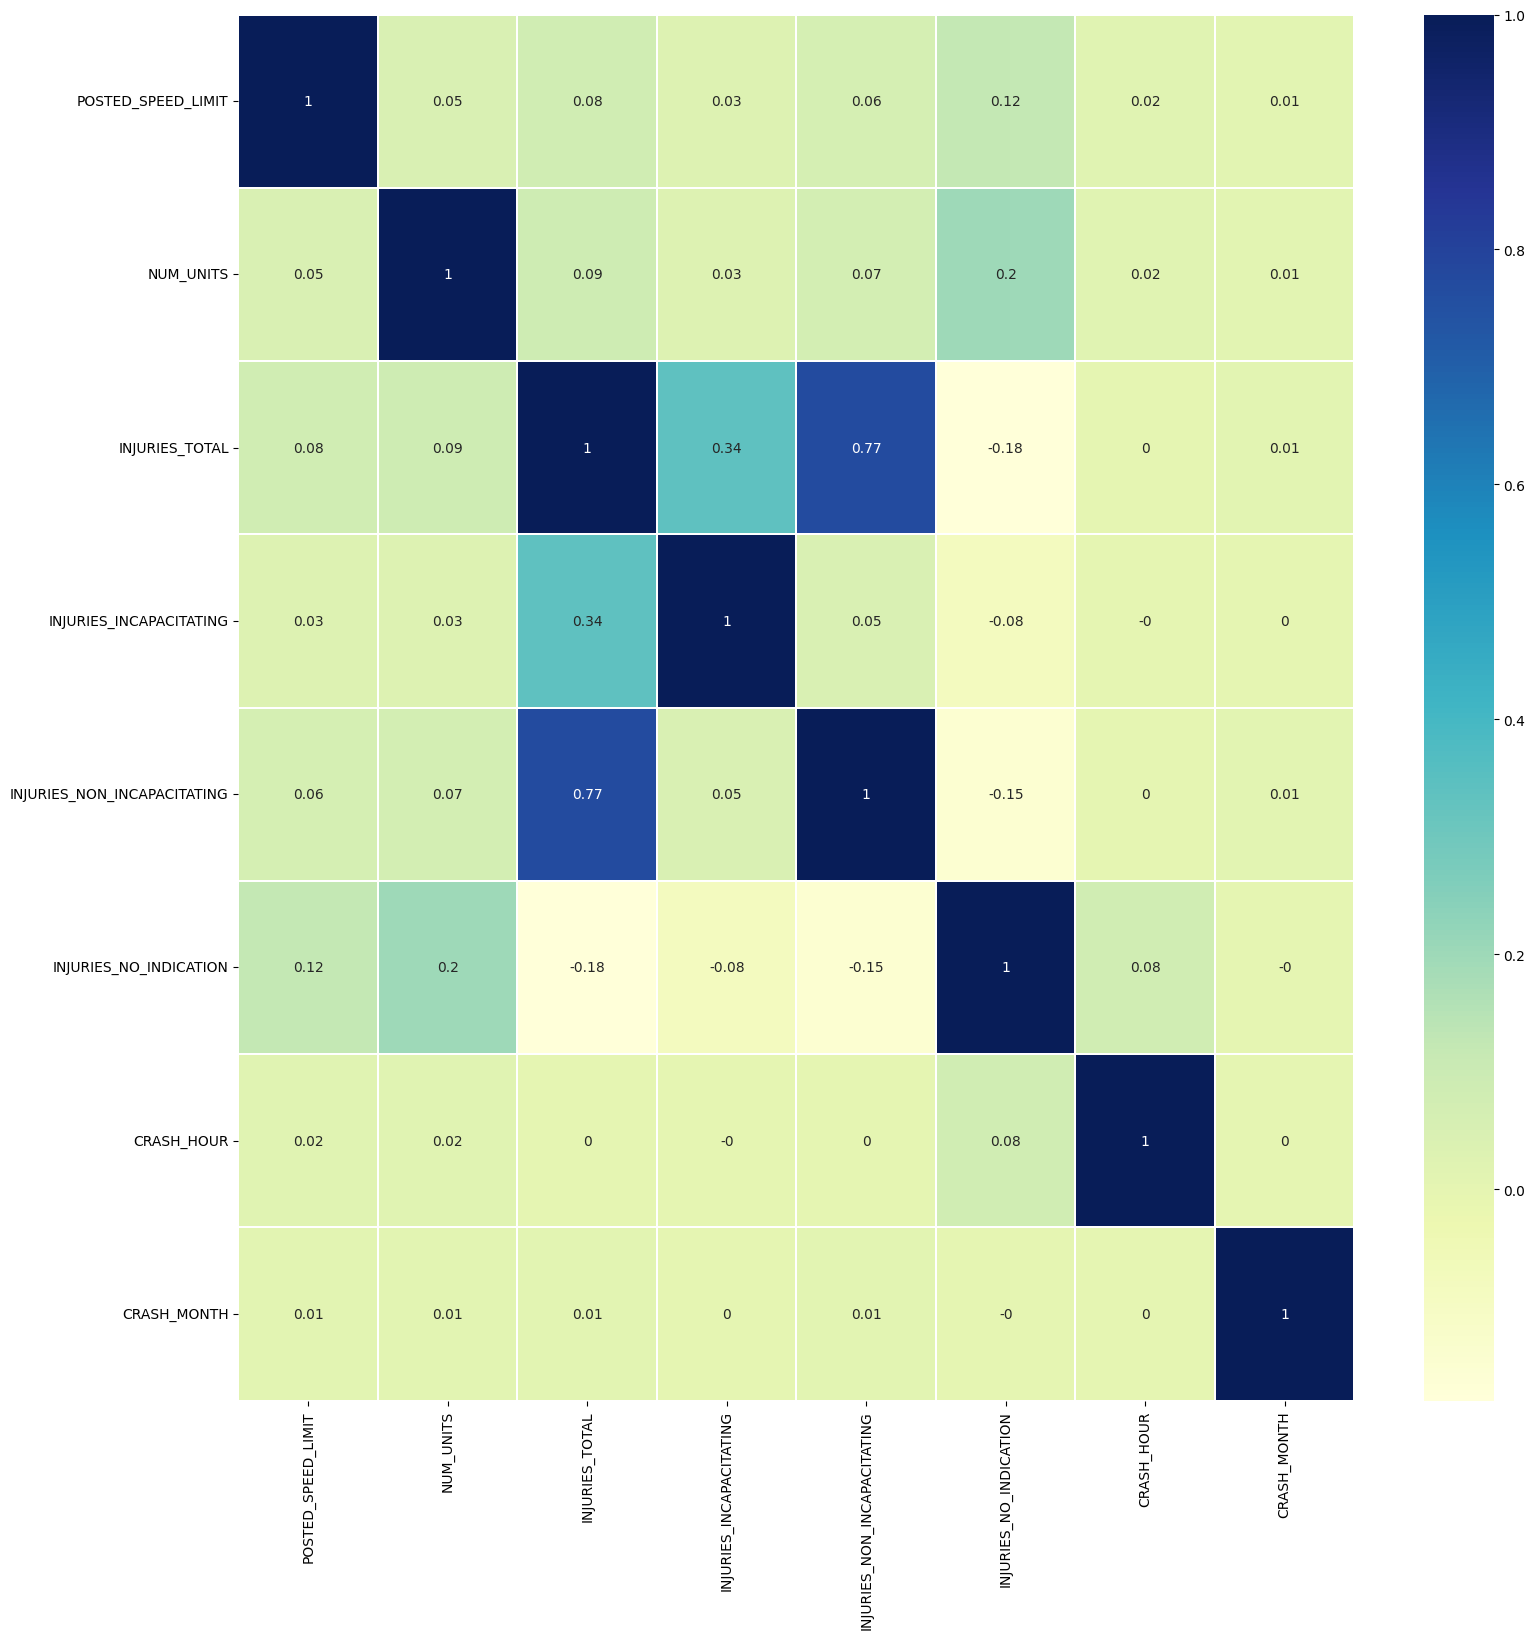

In [24]:
# Show the correlation matrix.
X_train = variables_num_corr(X_train, list_num, 0.7)

In [25]:
# We are interested in the INJURIES_TOTAL column. Thus, we drop INJURIES_NON_INCAPACITATING. 
X_train = X_train.drop(columns=["INJURIES_NON_INCAPACITATING"])
X_test = X_test.drop(columns=["INJURIES_NON_INCAPACITATING"])
list_num.remove("INJURIES_NON_INCAPACITATING")

# Feature engineering
## Binning

### Numerical variables

In [26]:
# BINS_NUMERICAL_TRAIN
# The function creates bins based on absolute cuts and quantile cuts.
"""
def bins_numerical_train(dataframe, list_vars, count_bins):
    # Initiate dictonaries for both types.
    bins_dict = {}  
    qbins_dict = {}  

    # Calculate bins for each variable.
    for i in list_vars:
        # Apply binning on training data - absolute borders.
        _, bins = pd.cut(dataframe[i], count_bins, include_lowest=True, duplicates="drop",  retbins=True)
        dataframe[i + "_bin"] = pd.cut(dataframe[i], bins, include_lowest=True, duplicates="drop").astype(str)

        # Apply binning on training data - relative borders (will be stored for testing data).
        _, qbins = pd.qcut(dataframe[i], count_bins, duplicates="drop", retbins=True)
        dataframe[i + "_qbin"] = pd.cut(dataframe[i], qbins, duplicates="drop", include_lowest=True,).astype(str)

        # Store information about bin cuts. 
        bins_dict[i] = bins
        qbins_dict[i] = qbins
    return dataframe, bins_dict, qbins_dict
"""

'\ndef bins_numerical_train(dataframe, list_vars, count_bins):\n    # Initiate dictonaries for both types.\n    bins_dict = {}  \n    qbins_dict = {}  \n\n    # Calculate bins for each variable.\n    for i in list_vars:\n        # Apply binning on training data - absolute borders.\n        _, bins = pd.cut(dataframe[i], count_bins, include_lowest=True, duplicates="drop",  retbins=True)\n        dataframe[i + "_bin"] = pd.cut(dataframe[i], bins, include_lowest=True, duplicates="drop").astype(str)\n\n        # Apply binning on training data - relative borders (will be stored for testing data).\n        _, qbins = pd.qcut(dataframe[i], count_bins, duplicates="drop", retbins=True)\n        dataframe[i + "_qbin"] = pd.cut(dataframe[i], qbins, duplicates="drop", include_lowest=True,).astype(str)\n\n        # Store information about bin cuts. \n        bins_dict[i] = bins\n        qbins_dict[i] = qbins\n    return dataframe, bins_dict, qbins_dict\n'

In [27]:
"""
X_train, bins_train, qbins_train = bins_numerical_train(X_train, list_num, count_bins=5)
"""

'\nX_train, bins_train, qbins_train = bins_numerical_train(X_train, list_num, count_bins=5)\n'

In [28]:
# BINS_NUMERICAL_TEST
# The function applies binning calculated on the train data to the test data. In case there is a new value in test data
# that has not been observed in train data, NaN will be assigned. These NaN values need to be dropped.
"""
def bins_numerical_test(dataframe, bins, qbins):
    # Bins
    for i, j in bins.items():
        dataframe[i + "_bin"] = pd.cut(dataframe[i], j, include_lowest=True, duplicates="drop").astype(str)
        dataframe = dataframe[ dataframe[i + "_bin"] != "nan" ]
    # Qbins
    for i, j in qbins.items():
        dataframe[i + "_qbin"] = pd.cut(dataframe[i], j, include_lowest=True, duplicates="drop").astype(str)
        dataframe = dataframe[ dataframe[i + "_qbin"] != "nan" ]    
    return dataframe
"""

'\ndef bins_numerical_test(dataframe, bins, qbins):\n    # Bins\n    for i, j in bins.items():\n        dataframe[i + "_bin"] = pd.cut(dataframe[i], j, include_lowest=True, duplicates="drop").astype(str)\n        dataframe = dataframe[ dataframe[i + "_bin"] != "nan" ]\n    # Qbins\n    for i, j in qbins.items():\n        dataframe[i + "_qbin"] = pd.cut(dataframe[i], j, include_lowest=True, duplicates="drop").astype(str)\n        dataframe = dataframe[ dataframe[i + "_qbin"] != "nan" ]    \n    return dataframe\n'

In [29]:
"""
X_test = bins_numerical_test(X_test, bins_train, qbins_train)
"""

'\nX_test = bins_numerical_test(X_test, bins_train, qbins_train)\n'

### Categorical variables

In [30]:
# BINS_CATEGORICAL
# The function replaces values with lower occurrence than the chosen threshold. The alternative value is set to "OTHER".
def bins_categorical(df_train, df_test, list_variables, treshold):
    mapping_dict = {} 
    for var in list_variables:
        for key,value in (df_train[var].value_counts()/len(df_train)).to_dict().items():
            if value > treshold: 
                mapping_dict[key] = key
            else:
                mapping_dict[key] = 'OTHER'
        df_train[var] = df_train[var].map(mapping_dict)
        df_test[var] = df_test[var].map(mapping_dict)
    return df_train, df_test
####################################

In [31]:
bins_categorical(X_train, X_test, list_cat, 0.01)

(        POSTED_SPEED_LIMIT TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION  \
 196055                30.0            NO CONTROLS           NO CONTROLS   
 554804                30.0            NO CONTROLS           NO CONTROLS   
 704491                30.0            NO CONTROLS           NO CONTROLS   
 756682                30.0            NO CONTROLS           NO CONTROLS   
 219458                30.0         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
 ...                    ...                    ...                   ...   
 259491                30.0                UNKNOWN               UNKNOWN   
 366461                30.0         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
 132011                30.0            NO CONTROLS           NO CONTROLS   
 673114                35.0            NO CONTROLS           NO CONTROLS   
 122027                30.0      STOP SIGN/FLASHER  FUNCTIONING PROPERLY   
 
        WEATHER_CONDITION      LIGHTING_CONDITION  \
 196055              RAIN  DARKNE

In [32]:
# Additional mapping for specific variables to decrease the number of unique values. 
X_train, X_test = bins_categorical(X_train, X_test, ["PRIM_CONTRIBUTORY_CAUSE"], 0.04)
X_train, X_test = bins_categorical(X_train, X_test, ["SEC_CONTRIBUTORY_CAUSE"], 0.02)
X_train, X_test = bins_categorical(X_train, X_test, ["TRAFFICWAY_TYPE"], 0.05)
X_train, X_test = bins_categorical(X_train, X_test,  ["FIRST_CRASH_TYPE"], 0.04)

## Dummy variables

In [33]:
# VARIABLES_DUMMIES
# The function creates dummy variables for each variable from the list. These variables are supposed to be categorical.  
def variables_dummies(dataframe, list_var, drop = False):
    for i in list_var:
        df_dummies = pd.get_dummies(dataframe[i], drop_first = False).rename(columns=lambda x: i + "_" + str(x))
        dataframe = pd.concat([dataframe, df_dummies], axis = 1)
        if drop:
            dataframe = dataframe.drop(i, axis = 1)
    return dataframe
######################################### 

In [34]:
# Apply the function on both dataframes
X_train = variables_dummies(X_train, list_cat)
X_test = variables_dummies(X_test, list_cat)


In [35]:
# All categorical variables and all bins are now encoded, so we can drop the original columns.
X_test = X_test.drop(columns=list_cat)
X_train = X_train.drop(columns=list_cat)


In [36]:
# MODEL_ENCODING
# The function encodes the dependent (categorical) variable. 

def model_encoding(train, test):
    train = train.astype('category').cat.codes
    test = test.astype('category').cat.codes
    return train, test
######################################### 

In [37]:
Y_train.groupby(Y_train).size()

DAMAGE
LESS THAN $1,500    211342
OVER $1,500         343186
Name: DAMAGE, dtype: int64

In [38]:
Y_test.groupby(Y_test).size()

DAMAGE
LESS THAN $1,500     90917
OVER $1,500         146738
Name: DAMAGE, dtype: int64

In [39]:
# Encode the Y.  
Y_train = model_encoding(Y_train, Y_test)[0]
Y_test = model_encoding(Y_train, Y_test)[1]

In [40]:
Y_train.groupby(Y_train).size()

0    211342
1    343186
dtype: int64

In [41]:
Y_test.groupby(Y_test).size()

0     90917
1    146738
dtype: int64

In [42]:
X_test_copy = X_test.copy()

## Models

In [43]:
# standard scaling

scaler = StandardScaler()
scaler.fit(X_train)

#Applying scaler on xtrain
X_train = scaler.transform(X_train)


#Applying scaler on xtest
X_test = scaler.transform(X_test)


StandardScaler()

In [44]:
rf_clf = RandomForestClassifier(n_estimators=12, criterion = 'entropy', max_depth = 32, class_weight = "balanced", min_samples_split = 8, min_samples_leaf= 2, random_state = 42)

rf_clf.fit(X_train, Y_train)

rf_train_pred = rf_clf.predict(X_train)
rf_test_pred = rf_clf.predict(X_test)
print(classification_report(Y_test, rf_test_pred))

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=32, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=12, random_state=42)

              precision    recall  f1-score   support

           0       0.51      0.69      0.58     90917
           1       0.75      0.59      0.66    146738

    accuracy                           0.62    237655
   macro avg       0.63      0.64      0.62    237655
weighted avg       0.66      0.62      0.63    237655



[Text(0.5, 1.0, 'Confusion Matrix')]

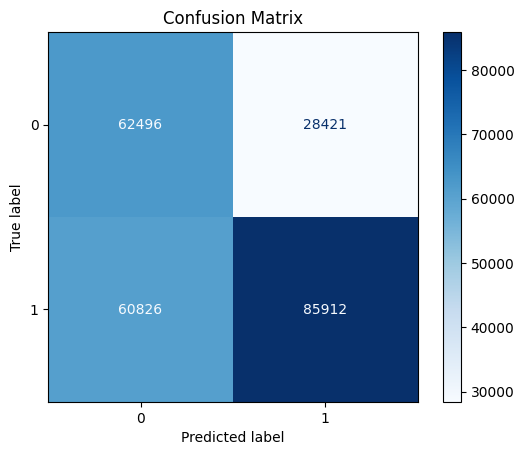

In [45]:
# confusion matrix for testing data
cm = confusion_matrix(Y_test, rf_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='.0f')
disp.ax_.set(title='Confusion Matrix')
plt.show()

In [46]:
# optimized LR
lr_clf = LogisticRegression(penalty='l1',
                            C=61.24806805925977,
                            class_weight='balanced',
                            solver='liblinear',
                            max_iter=930,
                            tol=2.259279742015695e-05,
                            fit_intercept=True,
                            intercept_scaling=0.0008953276247642705)
lr_clf.fit(X_train, Y_train)

lr_train_pred = lr_clf.predict(X_train)
lr_test_pred = lr_clf.predict(X_test)

#print(classification_report(Y_train, lr_train_pred))
print(classification_report(Y_test, lr_test_pred))

LogisticRegression(C=61.24806805925977, class_weight='balanced',
                   intercept_scaling=0.0008953276247642705, max_iter=930,
                   penalty='l1', solver='liblinear', tol=2.259279742015695e-05)

              precision    recall  f1-score   support

           0       0.49      0.78      0.60     90917
           1       0.78      0.49      0.60    146738

    accuracy                           0.60    237655
   macro avg       0.64      0.64      0.60    237655
weighted avg       0.67      0.60      0.60    237655



[Text(0.5, 1.0, 'Confusion Matrix')]

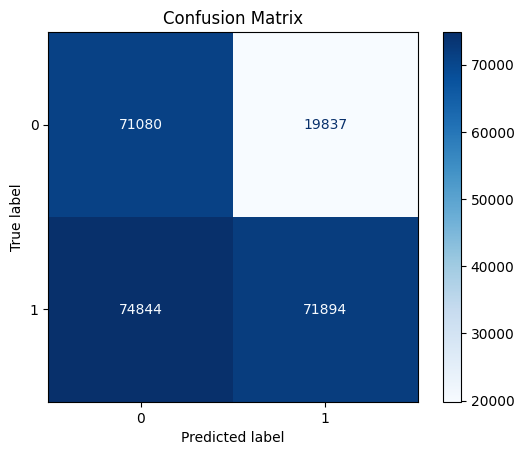

In [47]:
# confusion matrix for testing data
cm = confusion_matrix(Y_test, lr_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_clf.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='.0f')
disp.ax_.set(title='Confusion Matrix')
plt.show()

In [48]:
from catboost import CatBoostClassifier

In [49]:

# optimized catboost model application
cb_clf = CatBoostClassifier(iterations=437,
                           learning_rate=0.412,
                           depth=8,
                           l2_leaf_reg=0.98, #L2 regularization coefficient to prevent overfitting
                           loss_function='MultiClass',
                           random_seed=42)
cb_clf.fit(X_train, Y_train)
cb_train_pred = cb_clf.predict(X_train)
cb_test_pred = cb_clf.predict(X_test)

print(classification_report(Y_test, cb_test_pred))

0:	learn: 0.6424396	total: 297ms	remaining: 2m 9s
1:	learn: 0.6210012	total: 423ms	remaining: 1m 31s
2:	learn: 0.6110021	total: 534ms	remaining: 1m 17s
3:	learn: 0.6055773	total: 656ms	remaining: 1m 11s
4:	learn: 0.6019643	total: 780ms	remaining: 1m 7s
5:	learn: 0.6000821	total: 897ms	remaining: 1m 4s
6:	learn: 0.5984530	total: 1.03s	remaining: 1m 3s
7:	learn: 0.5974554	total: 1.16s	remaining: 1m 2s
8:	learn: 0.5959894	total: 1.3s	remaining: 1m 1s
9:	learn: 0.5951378	total: 1.42s	remaining: 1m
10:	learn: 0.5942625	total: 1.51s	remaining: 58.6s
11:	learn: 0.5936316	total: 1.64s	remaining: 58s
12:	learn: 0.5931214	total: 1.74s	remaining: 56.7s
13:	learn: 0.5921051	total: 1.84s	remaining: 55.7s
14:	learn: 0.5914371	total: 1.94s	remaining: 54.6s
15:	learn: 0.5909940	total: 2.03s	remaining: 53.4s
16:	learn: 0.5906658	total: 2.13s	remaining: 52.5s
17:	learn: 0.5903616	total: 2.23s	remaining: 51.8s
18:	learn: 0.5899688	total: 2.31s	remaining: 50.8s
19:	learn: 0.5895784	total: 2.4s	remaining: 

              precision    recall  f1-score   support

           0       0.57      0.43      0.49     90917
           1       0.69      0.80      0.74    146738

    accuracy                           0.66    237655
   macro avg       0.63      0.61      0.62    237655
weighted avg       0.64      0.66      0.64    237655



[Text(0.5, 1.0, 'Confusion Matrix')]

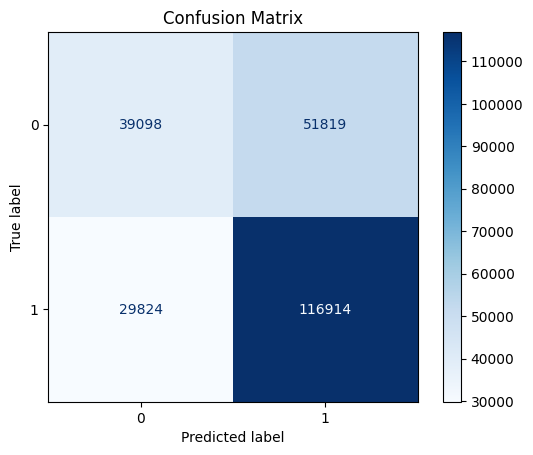

In [50]:
# confusion matrix for testing data
cm = confusion_matrix(Y_test, cb_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cb_clf.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='.0f')
disp.ax_.set(title='Confusion Matrix')
plt.show()

In [51]:
!pip install anvil-uplink

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [52]:
#Establish connection to frontend 
import anvil.server

anvil.server.connect("server_C37466WG3MWNO2AE5IPQIIBT-474F3KYBIKYDFSTP")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [53]:
"""
@anvil.server.callable
def get_unique_vals(column_list):
    
    unique_val_dict = {} 
    
    for column in column_list:
        unique_val_dict[column] = list(df_graphs_cat3[column].unique())

    return unique_val_dict
"""


'\n@anvil.server.callable\ndef get_unique_vals(column_list):\n    \n    unique_val_dict = {} \n    \n    for column in column_list:\n        unique_val_dict[column] = list(df_graphs_cat3[column].unique())\n\n    return unique_val_dict\n'

In [54]:
@anvil.server.callable
def estimate(solution_choice,value_dict):
    df_copy = X_test_copy.iloc[0:1,:].copy().reset_index().set_index("index")
    for col in df_copy.columns:
        df_copy[col].values[:] = 0
    
    for key in value_dict.keys():
        if key in df_copy:
            df_copy[key] = value_dict[key]
        else:
            df_copy[key +"_"+str(value_dict[key])] = True
    df_copy = scaler.transform(df_copy)
    
    match solution_choice:
        case "CatBoost":
            return cb_clf.predict(df_copy)
        case "Logistic Regression":
            return lr_clf.predict(df_copy)
        case "Random Forest":
            return rf_clf.predict(df_copy)

In [ ]:
Y_train